# Final course project: **Binary Weather Classification**

## Introduction

The following work deals with a binary (two classes) classification of images problem. The dataset is made up of images of outdoors under two different kinds of weather: sunny or cloudy. In other words, the problem is detecting if the image represents a sunny or cloudy weather, with images taken from the ground (not satellite imagery). The image may be a photo of a landscape, a city, a person, etc. and may contain lots of different objects in it.

The dataset was uploaded by me to Kaggle, it has of two folders: 

- The __train__ (training) folder: contains _'sunny'_ and _'cloudy'_ folders, each one has 5000 RGB jpg images. This dataset is not my work, I took it from this [webpage](https://www.cse.cuhk.edu.hk/leojia/projects/weatherclassify/index.htm).
- The __test__ folder: contains _'sunny'_ and _'cloudy'_ folders, with 153 and 100 RGB jpg images respectively. This dataset is mostly made up of my own work, but I took some pictures from the [Creative Commons webpage](http://creativecommons.org) too. 


To start with, I will import the libraries that I will be using throughout this work.

In [182]:
import os #to communicate with the opertive system
import pandas as pd #database-handling library
import numpy as np #vector operations
from PIL import Image

#Libraries related with PyTorch
import torch #PyTorch library
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn as nn #Neural networks library
import torch.nn.functional as F

#Useful libraries for plotting
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline 
#plots in the line below the code, inside the notebook 

In [183]:
#Import Jovian to commit and save my work there
!pip install jovian --upgrade -q
import jovian

In [184]:
project_name = 'Final_project: Binary weather classification'

## Exploring and preparing the dataset

The ___Exploring the dataset___ notebook is stored in [Jovian](https://jovian.ml/paula-rj/exploring-data-binary-weather-classification) and [Kaggle](https://www.kaggle.com/polavr/exploring-the-data) and has more detailed explanations and graphics. In this section I will just prepare the dataset. I splited the exploring from the rest of the work just for comfort, this notebook was turning too large and it was a little bit annoying. 

In [185]:
train_dir = '/kaggle/input/twoclass-weather-classification/train' #path where the training dataset is
classes = os.listdir(train_dir) #classes = the folders that the train folder contains
#num_classes = len(classes)
print(classes)

['cloudy', 'sunny']


In [186]:
test_dir = '/kaggle/input/twoclass-weather-classification/test' #path where the test dataset is
classes = os.listdir(train_dir)
print(classes)

['cloudy', 'sunny']


Now, I want to convert the jpg images into tensors and load them into a dataset. For that purpose, I will use the **ImageFolder** class from torchvision.dataset. This function takes the root directory path where all the classes are and loads all the data into a dataset. Optionally, it takes in a PIL image and returns a transformed version. In order to transform images into PyTorch tensors, I will use this option together with the function **ToTensor()** form torchvision.transform

In [187]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(train_dir, transform=tt.ToTensor())

The __dataset__[0:4999] contains **cloudy** images which are labeled with a **0**. 

The __dataset__[5000:9999] contains **sunny** images which are labeled with a **1**. 

Next, I will define the validation dataset. I will take some images from the train dataset, a 20% = 2000, for this purpose. I do this instead of using the test dataset as the validation dataset because there are too few images in the test dataset (just 253), it's just 2,53% of the size of the train dataset. This is the code [source](https://gist.github.com/bertcarremans/679624f369ed9270472e37f8333244f5) for the following function.

In [188]:
# Copyright 2014-2017 Bert Carremans
# Author: Bert Carremans <bertcarremans.be>
#
# License: BSD 3 clause

import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [189]:
img_train_test_split(train_dir, 0.80)

Copied 3992 images to data/train/cloudy
Copied 1008 images to data/validation/cloudy
Copied 3985 images to data/train/sunny
Copied 1015 images to data/validation/sunny


In [190]:
#Redefine the direction where the data is stored
train_dir = './data/train/'
val_dir = './data/validation/'

Finally I will define the batch size because I will need it from now on.

In [191]:
batch_size = 64

## Data Augmentation

First I will define a function to obtain the mean and standart deviation of a dataset stored in 'path' (idea [here](http://https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch)) and then I will apply the Normalize transform
_torchvision.transforms.Normalize(mean, std, inplace=False)_ to both training and validation datasets, each one with their own mean and standart deviation. For the training dataset, I will aplly the normalization togheter with some other transformations.

In [192]:
#dataset = TensorDataset(data, labels)
#loader = DataLoader(dataset, batch_size)

def compute_mean_std(path, batch_size):
    '''Computes a channel-wise mean and standart deviation for a bunch of images stored in a directory.
    Parameters
    ----------
    path: string. Path of the directory where the images are stored.
    batch_size: int. Size of the batch.
    
    Returns:
    -------
    stats: Tuple containing mean and standart deviation for each channel. Example: ((0.5,0.5,0.5),(0.5,0.5,0.5))'''
    
    dataset = ImageFolder(path, transform=tt.ToTensor())
    loader = DataLoader(dataset, batch_size)
    
    nimages = 0
    mean = 0.
    var = 0.

    for batch, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std 
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)
        
    # Final step
    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    stats = (mean, std)
    return stats

In [193]:
train_stat = compute_mean_std(train_dir, batch_size)
train_stat

(tensor([0.4757, 0.4962, 0.4717]), tensor([0.2405, 0.2422, 0.2728]))

In [194]:
val_stat = compute_mean_std(val_dir, batch_size)
val_stat

(tensor([0.4727, 0.4948, 0.4727]), tensor([0.2412, 0.2427, 0.2732]))

In [195]:
# Data transforms 
train_tfms = tt.Compose([
                         tt.RandomRotation(45, resample=False, expand=False, center=(100,100), fill=None), 
                         #randomly choose an image to rotate 45°
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(), 
                         tt.RandomErasing(inplace=True),
                         #randomly erase a part of an image
                         tt.Normalize(*train_stat,inplace=True)
                        ])

val_tfms = tt.Compose([
                        tt.ToTensor(),
                        tt.Normalize(*val_stat,inplace=False)
                        ])

In [196]:
# PyTorch datasets
dataset_train_tfms = ImageFolder(train_dir, train_tfms) #splitted training dataset + all the transformations applied
dataset_val_tfms = ImageFolder(val_dir, val_tfms) #validation dataset + normalize transformation applied

In [197]:
#Check the lenghts of each dataset
len(dataset_train_tfms), len(dataset_val_tfms)


(8029, 2082)

In [198]:
# PyTorch data loaders
train_dl = DataLoader(dataset_train_tfms, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(dataset_val_tfms, batch_size*2, num_workers=4, pin_memory=True)

In [199]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

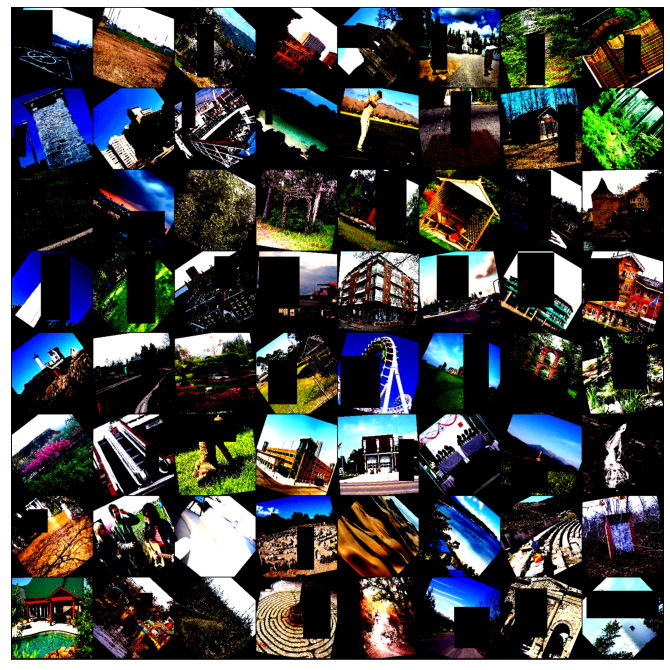

In [200]:
show_batch(train_dl)

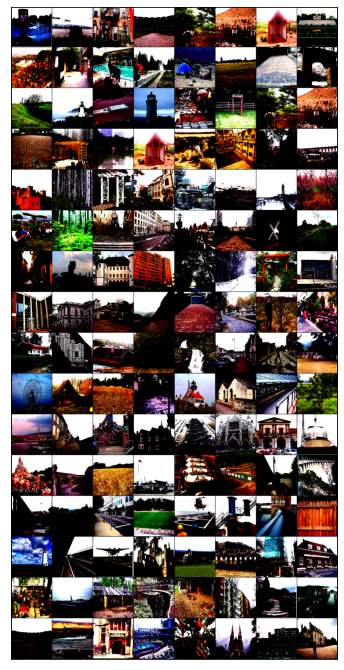

In [201]:
show_batch(val_dl)

## Moving the data to GPU

Now I will define a series of functions (all seen during the course) that executes this task. They're specially useful if we have a GPU.

In [202]:
#This function detects if a GPU is available
torch.cuda.is_available()

True

In [203]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [204]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [205]:
#Moves data to device.
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

## Model

In [206]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        #print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
         #   epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Model 1: Vanilla CNN 
Idea taken from the recommended [webpage](http://https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee) in lecture 5.

In [207]:
class VanillaCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5)) #out = 64x40x40
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(5)) #out = 128x8x8
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)) #out = 256x4x4
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.3), #randomly zeroes some elements,for regularization and preventing the co-adaptation of neurons
            nn.Linear(1024,5)
        )
           
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

### Model 2: ResNet9

In [208]:
def conv_block(in_channels, out_channels, pool_num=2, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), #Observation! Batch norm
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(pool_num))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) #pool=False
        self.conv2 = conv_block(64, 128, pool_num=5, pool=True) #out = 128x40x40
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) #pool=False, out = 128x40x40
        
        self.conv3 = conv_block(128, 256, pool=True, pool_num=5) #out = 256x8x8
        self.conv4 = conv_block(256, 512, pool=True) #out = 512x4x4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #pool=False, out = 512x4x4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # out = 512x1x1
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)

        return out

## Trainig the model

In [209]:
#Without lr cycle, grad clip and weight decay

#@torch.no_grad()
#def evaluate(model, val_loader):
#    model.eval()
#    outputs = [model.validation_step(batch) for batch in val_loader]
#    return model.validation_epoch_end(outputs)

#def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.ASGD):
#    history = []
#    optimizer = opt_func(model.parameters(), lr)
#    for epoch in range(epochs):
#        # Training Phase 
#        model.train()
#        train_losses = []
#        for batch in train_loader:
#            loss = model.training_step(batch)
#            train_losses.append(loss)
#            loss.backward()
#            optimizer.step()
#            optimizer.zero_grad()
#        # Validation phase
#        result = evaluate(model, val_loader)
#        result['train_loss'] = torch.stack(train_losses).mean().item()
#        model.epoch_end(epoch, result)
#        history.append(result)
#    return history

In [210]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.ASGD): #Averege SGD
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=None, epochs=epochs, steps_per_epoch=len(train_loader), 
                                        pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85,
                                        max_momentum=0.95)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Initial parameters. Choose the model.

In [211]:
#ModelCNN
#model = to_device(VanillaCNN(), device)

#Model ResNet9
model = to_device(ResNet9(3, 2), device) #3=in_channels, 2=out channels=num classes

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [212]:
#Evaluate model and define history
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6917954087257385, 'val_acc': 0.5243566036224365}]

In [213]:
epochs = 40
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adamax

#%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00006, train_loss: 0.3936, val_loss: 0.4198, val_acc: 0.7902
Epoch [1], last_lr: 0.00010, train_loss: 0.2929, val_loss: 0.3578, val_acc: 0.8373
Epoch [2], last_lr: 0.00018, train_loss: 0.2717, val_loss: 0.2393, val_acc: 0.9076
Epoch [3], last_lr: 0.00028, train_loss: 0.2667, val_loss: 0.2343, val_acc: 0.9032
Epoch [4], last_lr: 0.00040, train_loss: 0.2689, val_loss: 0.2366, val_acc: 0.9006
Epoch [5], last_lr: 0.00052, train_loss: 0.2563, val_loss: 0.2467, val_acc: 0.8970
Epoch [6], last_lr: 0.00064, train_loss: 0.2417, val_loss: 0.2182, val_acc: 0.9127
Epoch [7], last_lr: 0.00076, train_loss: 0.2396, val_loss: 0.2428, val_acc: 0.9015
Epoch [8], last_lr: 0.00086, train_loss: 0.2224, val_loss: 0.2153, val_acc: 0.9115
Epoch [9], last_lr: 0.00094, train_loss: 0.2211, val_loss: 0.2725, val_acc: 0.8984
Epoch [10], last_lr: 0.00098, train_loss: 0.2211, val_loss: 0.2747, val_acc: 0.8861
Epoch [11], last_lr: 0.00100, train_loss: 0.2228, val_loss: 0.2397, val_acc: 0.9088
Ep

## Evaluating and recording results

Plot acurracy, train loss vs val loss and learning rates vs number of epochs.

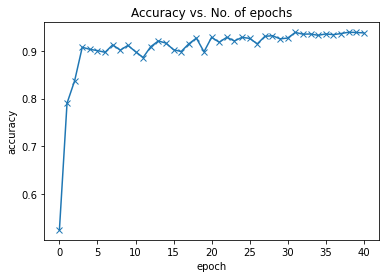

In [214]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

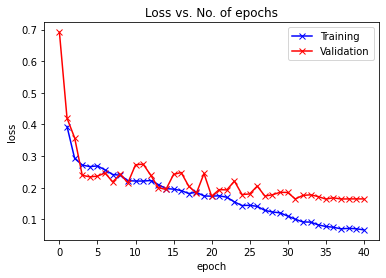

In [215]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

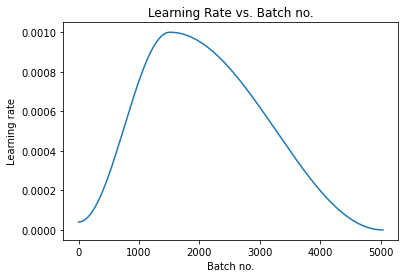

In [216]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

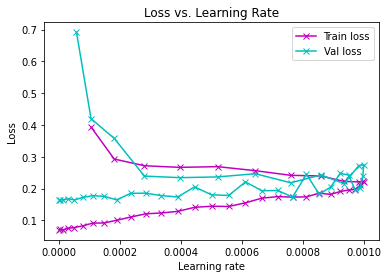

In [217]:
#Learnig rate vs loss

def plot_lrs_loss(history, epochs):
    
    train_losses = [] #creates list where the training losses will be stores
    val_losses = [] #creates list where the val losses will be stores
    last_lrs = [] #creates list where the LAST learning rates will be stored 
    
    for i in range(0,epochs):       #epochs==len(history) in this algoritm
        train_losses.append(history[i].get('train_loss'))
        val_losses.append(history[i].get('val_loss'))
        list_lrs = history[i+1].get('lrs', [])
        last_lrs.append(list_lrs[-1])
        
    plt.plot(last_lrs,train_losses, '-xm')
    plt.plot(last_lrs,val_losses, '-xc')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.legend(['Train loss','Val loss'])
    plt.title('Loss vs. Learning Rate');
    
plot_lrs_loss(history, epochs)

Using the __test__ dataset to evaluate the model's performance.

In [218]:
test_stat = compute_mean_std(train_dir, batch_size)

test_tfms = tt.Compose([
                        tt.ToTensor(),
                        tt.Normalize(*test_stat,inplace=False)
                        ])

test_stat

(tensor([0.4757, 0.4962, 0.4717]), tensor([0.2405, 0.2422, 0.2728]))

In [219]:
test_dataset_tfms = ImageFolder(test_dir, test_tfms) 
test_dl = DataLoader(test_dataset_tfms, batch_size, num_workers=4, pin_memory=True)

#Moves data to device.
test_loader = DeviceDataLoader(test_dl, device)
len(test_dataset_tfms)

253

In [220]:
#Test
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


In [221]:
c_count = 0
s_count = 0

for i in range(len(test_dataset_tfms)):
    img, label = test_dataset_tfms[i]
    #plt.imshow(img.permute(1, 2, 0))
    if i<100:
        if (dataset.classes[label] == predict_image(img, model)):
            c_count= c_count+1
    else:
        if (dataset.classes[label] == predict_image(img, model)):
            s_count = s_count + 1        
    #print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
      
cok = (c_count/100)*100
sok = (s_count/153)*100
print('% of cloudy well labelled: ', cok, '%')
print('% of sunny well labelled: ', sok, '%')

% of cloudy well labelled:  99.0 %
% of sunny well labelled:  75.81699346405229 %


As a final step, let's also look at the overall loss and accuracy of the model
on the test set, and record using jovian. 
We expect these values to be similar to those for the validation set. 
If not, we might need a better validation set that has similar data and distribution as the test set.

In [222]:
test_loader = DeviceDataLoader(DataLoader(test_dataset_tfms, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5319281220436096, 'val_acc': 0.8494062423706055}

In [223]:
torch.save(model.state_dict(), 'Final_project: Binary weather classification')

jovian.reset()

jovian.log_hyperparams(Model='VanillaCNN', 
                       epochs=epochs, 
                       batch_size= batch_size,
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)


[jovian] Hyperparams logged.


In [225]:
jovian.log_metrics(test_loss=0.5319281220436096, test_acc= 0.8494062423706055, c_ok=cok, s_ok = sok)

jovian.commit(project=project_name, outputs=['Final_project: Binary weather classification.pth'], environment=None)

[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/paula-rj/Final_project: Binary weather classification


<IPython.core.display.Javascript object>

## Conclution

The model which reached the highest validationn accuracy was ResNet9 with Adamax as optimization function and a max learning rate of 0.001. But the validation loss and accuracy for the  test dataset were not the best. The best metrix in this case were for the VanillaCNN model with Adamax as the optimization function and a max learning rate of 0.001; the validation accuracy was 0.86513	and the loss was 0.39462 (test).

One thing that caught my attention was the fact that within the images in the test dataset, the model always predicted the cloudy images (wiyh 99% accuracy) better than sunny images, I still don't realize why. 

### Further work

In regards to this job, I've tried Adam and Adamax as optimization function but I'd like to try more optimization functions and compare which is the best through a graphic. Also, I'd like to tried some other architectures, for example the one that the original work mentions.

As for making the work more complex, I think the next step would be to add more kinds of climates, therefore more classes.

And of course, as far as my learning is concerned, I should read a little more, deepen the mathematical concepts, try to understand the underlying concepts better and keep on practicing. In any case, it is incredible how much I learned in such a short time and this motivated me to continue learning. 